In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
import numpy as np
import tensorflow as tf
import random
import edward as ed

In [3]:
# Reload all packages - make debugging easier
%load_ext autoreload
%autoreload 2

Load MovieLens data

In [4]:
from movieLensAnalyzer import MovieLensAnalyzer 
import random 
movieLensAnalyzer = MovieLensAnalyzer()

# We'll only use the trainRatingMatrix for now (Note that Soon made train/test split by time).
R_ = movieLensAnalyzer.trainRatingMatrix

percentageZero = 0.3
mask_trin = np.ones(R_.shape) # == 0 if we cannot train on i,j rating
for i in range(mask_trin.shape[0]):
    for j in range(mask_trin.shape[1]):
        if R_[i][j] == 0: # rating does not exist
            mask_trin[i][j] = 0 # we cannot train on i,j rating
        elif (random.random() < percentageZero):
            mask_trin[i][j] = 0 # don't train on i,j rating

In [5]:
# # # OLD
# # R_    = np.array([[1,3,3,4,5],
# #                   [1,2,4,3,5],
# #                   [5,3,2,5,1]])
# # mask_trin = np.array([[1,1,1,1,1],
# #                       [1,0,0,0,0],
# #                       [1,1,1,1,1]])

----

In [6]:
from mf_nn_full_vi_edward import NNMF_FullVI_Edward

In [7]:
n_users, n_items = R_.shape

def plot_R(rhats, r, title=''):
    _, n_users, n_items = rhats.shape
    f, axes = plt.subplots(n_users, n_items, sharex=True, sharey=True)
    for i in range(n_users):
        for j in range(n_items):
            axes[i][j].axvline(x=r[i,j], color='r')
            axes[i][j].hist(rhats[:,i,j])
    f.suptitle(title)
    plt.show()

In [8]:
# Note: This takes a long time because it constructs a lot of graphs in tensorflow.
%time model = NNMF_FullVI_Edward(n_users, n_items, latent_dim=2, latent_dim_p=2)

CPU times: user 1min 6s, sys: 10.9 s, total: 1min 16s
Wall time: 52.1 s


Currently the model has the following interface; I haven't decided which one to keep yet:

```
model.prior               -> a (100, n_users, n_items) matrix, made up of 100 prior draws
model.posterior           -> a (100, n_users, n_items) matrix, made up of 100 posterior draws
model.posterior_map       -> a (n_users, n_items) matrix
model.get_prediction(i,j) -> a pair (map_estimate, variance) for user i, item j
```

In [9]:
model.train(R=R_, mask=mask_trin, n_iter=100)

100/100 [100%] ██████████████████████████████ Elapsed: 141s | Loss: 10778511.000


Visualize results:

In [10]:
model.get_prediction(1,2) # Sample prediction, output is (mean, variance)

(2.9297378, 1.6438375)

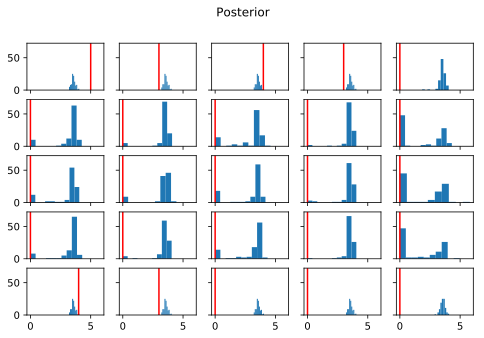

Mask:
[[ 1.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]]


In [11]:
# Plot first 5 users vs first 5 items
plot_R(model.posterior[:,0:5,0:5], R_[0:5,0:5], title='Posterior')
print("Mask:")
print(mask_trin[0:5,0:5])

# RMSE

In [12]:
from util import make_bandits_mask

# TODO user Soon's RMSE (but his assumes a True-False matrix?)
def rmse(R_hat, R, mask=None):
    '''
    If no mask given, calculate RMSE for entire rating matrix.
    If mask given, calculate RMSE only for entries where mask == 0 (the unseen entries)
    '''
    if mask is None:
        return np.sqrt(((R_hat - R) ** 2)[np.where(R != 0)].mean())
    else:
        mask_bandit = make_bandits_mask(mask, R)
        return np.sqrt(((R_hat - R) ** 2)[np.where(mask_bandit == 0)].mean())

print("RMSE all entries: ", rmse(model.posterior_map, R_))
print("RMSE for just entries we haven't seen: ", rmse(model.posterior_map, R_, mask_trin))

RMSE all entries:  1.08414515999
RMSE for just entries we haven't seen:  1.07842297996


# Regret

In [13]:
gamma = 0.9

In [14]:
def get_best_score(user, R, mask, gamma):
    '''
    user: user index
    R: true ratings matrix of size (n_users, n_items)
    mask: mask matrix of size (n_users, n_items), 1 if ratings is observed, 0 otherwise.
    '''
    mask_bandit = make_bandits_mask(mask, R)
    # Extract missing entries
    missing_ratings = R[user][np.where(mask_bandit[user] == 0)]
    # Sort biggest to smallest
    missing_ratings = missing_ratings[np.argsort(-missing_ratings)]
    best_score = 0
    discount = 1
    for r in missing_ratings:
        best_score += r * discount
        discount *= gamma
    return best_score

### $\epsilon$-greedy

Note: We should be retraining the model every time, but we don't do it here because it would be way too slow.

In [15]:
epsilon = 0.75

In [16]:
def get_egreedy_score(user, R, mask, gamma, model, epsilon, retrain=False):
    # TODO: retraining is prohibitively expensive here...
    
    my_mask = make_bandits_mask(mask, R) # Note: This returns a copy of mask.
    discount = 1
    score = 0
    
    n_iter = np.sum(my_mask[user] == 0)
    
    for _ in range(n_iter):
        user_ratings = model.posterior_map[user]
        user_indices = np.array(range(len(user_ratings)))
        user_ratings = user_ratings[my_mask[user] == 0]
        user_indices = user_indices[my_mask[user] == 0]

        if random.random() < epsilon:
            # Choose greedy action
            idx = np.argmax(user_ratings)
        else:
            # Choose random action
            idx = random.randint(0,len(user_ratings)-1)

        my_mask[user,user_indices[idx]] = 1
        score += R[user,user_indices[idx]] * discount
        discount *= gamma

        if retrain:
            model.train(R=R, mask=my_mask, n_iter=5000)
    
    return score

For each user with missing ratings, we compute the regret for that user.

Our total regret is the regret summed across all users.

<mark>NOTE</mark> This only calculates regret <strong>for one user</strong> and <strong>without retraining</strong> for sake of speed.

In [17]:
regret = 0
for user in range(n_users):
    # egreedy is random, so we run it a few times
    mean_egreedy_score = np.mean([get_egreedy_score(user, R_, mask_trin, gamma, model, epsilon) for _ in range(100)])
    regret += get_best_score(user, R_, mask_trin, gamma) - mean_egreedy_score
    break # TODO We just see it for the first user, otherwise it takes too long to run.

regret

9.2833101129941298